In [1]:
import pandas as pd
import os
from random import choices
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm
from src.utils import download_table, get_wandb_summaries
from src.data.utils import load_json, download_wandb_table
import wandb
from pprint import pprint
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
import collections
import glob 

import matplotlib.patches as mpatches
from src.data.hierarchical_bootstrapping import hierarchical_bootstrapping, bootstrapping
sns.color_palette

colors = sns.color_palette().as_hex()
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
api = wandb.Api()

def search_experiments(model="CNNToTransformerClassifier", task="PredictFluPos", notes="hourly temporal split", tags="pretrained", _n_runs=5):
    """
    returns experiments ids that match a given a model name, task, and notes. Should return one entry per run (i.e. 5)
    """
    
    filters={"summary_metrics.model": model, "summary_metrics.task": task, "notes": notes}
    
    if tags is not None:
        if isinstance(tags, dict) and "not" in tags:
            tags = {"$not": tags["not"]}
        filters["tags"] = tags
    
    query = api.runs(
            path="bdata/ICML-2023-Flu-Dataset",
            filters=filters,
            order="+summary_metrics.pl_seed"
    )

    return query

In [3]:
def get_prediction_tables(run_ids, entities=["mikeamerrill","safranchik"], projects=["ICML-2023-Flu-Dataset", "mobs"], no_mobs=False):
    if no_mobs:
        projects = ["ICML-2023-Flu-Dataset"]
    tables = []
    for run_id in run_ids:
        for entity in entities:
            for project in projects:
                # TODO: pull runs from the bdata/Homekit project 
                try:
                    tables.append(download_wandb_table(run_id.id, table_name="test_predictions", entity=entity, project=project))
                except:
                    continue
    return tables

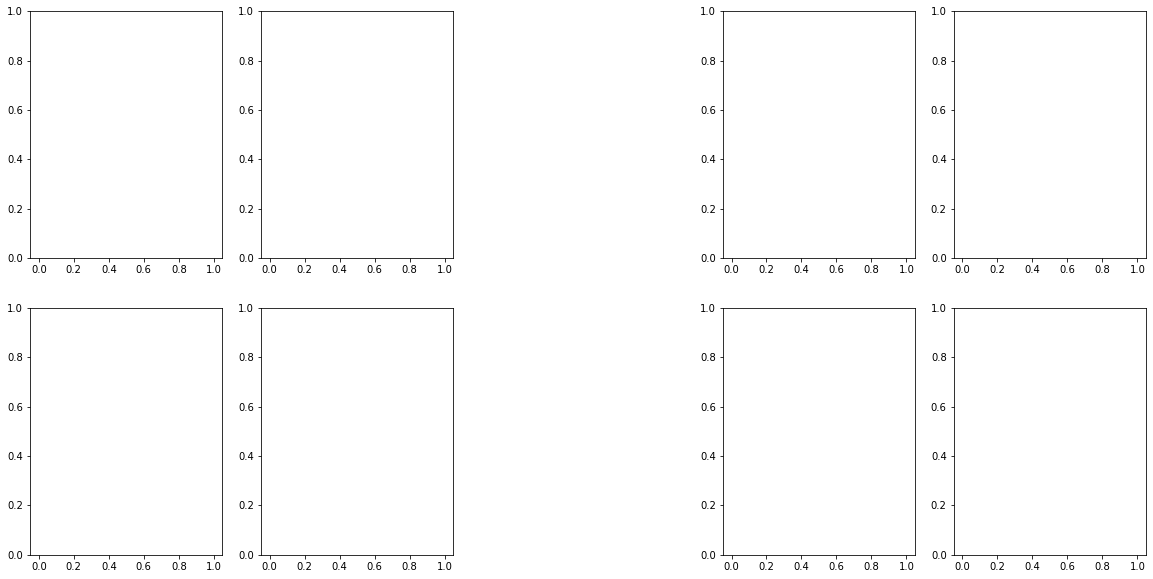

In [55]:

def to_subplot_ix(m, s, t):
    subplot_ix = (t + int(t/6) + 1)
    if m == 1:
        subplot_ix += 2 * len(tasks) + 1
    if s == 1:
        subplot_ix += len(tasks) + 1
    return subplot_ix

# initializes subplots
for s in [0, 1]:
    for m in [0, 1]:
        for t in range(len(tasks)):
            plt.subplot(2, 2*len(tasks)+1, to_subplot_ix(m, s, t))
            plt.xlim(-0.05, 1.05)
            

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

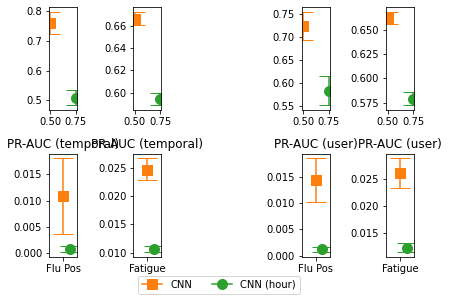

In [58]:
fig = plt.gcf()

fig.set_size_inches(30, 20)

metrics = [roc_auc_score, average_precision_score]
metric_names = ["AUROC", "PR-AUC"]

# format: model name, notes, label, color
models = [
#             ("CNNToTransformerClassifier", "temporal split", {"not": "pretrained"}, {"label": "CNN-Transformer", "color": colors[0], "marker":'s'}, 0),
#             ("CNNToTransformerClassifier", "user split", {"not": "pretrained"}, {"label": "CNN-Transformer", "color": colors[0], "marker":'s'}, 0),
    
          
            ("CNNClassifier", "temporal split", None, {"label": "CNN", "color": colors[1], "marker": "s"}, 1),
            ("CNNClassifier", "user split", None, {"label": "CNN", "color": colors[1], "marker": "s"}, 1),
            ("CNNClassifier", "hourly temporal split", None, {"label": "CNN (hour)", "color": colors[2], "marker": "o"}, 2),
            ("CNNClassifier", "hourly user split", None, {"label": "CNN (hour)", "color": colors[2], "marker": "o"}, 2),
          
#             ("TransformerClassifier", "hourly temporal split", None, {"label": "Transformer (hour)", "color": colors[3], "marker": "o"}, 3),
#             ("TransformerClassifier", "hourly user split", None, {"label": "Transformer (hour)", "color": colors[3], "marker": "o"}, 3),
    
#             ("ResNet", "hourly temporal split", None, {"label": "ResNet (hour)", "color": colors[6], "marker": "o"}, 4),
#             ("ResNet", "hourly user split", None, {"label": "ResNet (hour)", "color": colors[6], "marker": "o"}, 4),     
            
#             ("XGBoostClassifier", "hourly temporal split", None, {"label": "XGBoost (hour)", "color": colors[5], "marker": 'o'}, 5),
#             ("XGBoostClassifier", "hourly user split", None, {"label": "XGBoost (hour)", "color": colors[5], "marker": 'o'}, 5),
    
#             ("XGBoostClassifier", "daily temporal split", None, {"label": "XGBoost (day)", "color": colors[5], "marker": 'd'}),
#             ("XGBoostClassifier", "daily user split", None, {"label": "XGBoost (day)", "color": colors[5], "marker": 'd'})
        ]            

tasks = ["HomekitPredictFluPos", "HomekitPredictFatigue", "HomekitPredictCough", "HomekitPredictFluSymptoms", "HomekitPredictSevereFever"]
task_names = ["Flu Pos", "Fatigue", "Cough", "Symptoms", "Fever"]

tasks = ["HomekitPredictFluPos", "HomekitPredictFatigue"]
task_names = ["Flu Pos", "Fatigue"]

assert len(tasks) == len(task_names)

splits = ["user", "temporal"]


# fig, axs = plt.subplots(2, 2 * len(tasks), sharex=True, sharey=True)
# fig.set_size_inches(20, 10)

data = {"temporal": {"roc_auc_score": {}, "average_precision_score": {}},
        "user": {"roc_auc_score": {}, "average_precision_score": {}}}


axis_splits = np.arange(len(tasks)+1)


num_models = max(d[-1] for d in models)

width = 1/(num_models+2)




""" fills out the nested data dictionary """
for t, task in enumerate(tasks):
    for k, (model, note, tags, kwargs, order) in enumerate(models):

        s = 0 if "temporal" in note else 1
        
        run_ids = search_experiments(model, task, note, tags)
        tables = get_prediction_tables(run_ids, no_mobs=(model=="CNNToTransformerClassifier"))
        
        if not isinstance(tables, list):
            continue
            
        if len(tables) != 5:
            print("{}-{} with note \"{}\" and tags \"{}\" has length {}".format(model, task, note, tags, len(tables)))

            continue

        assert len(tables) == 5
                    
        # 40 model bootstraps lets us discard the bottom and top outliers to obtain a 95% CI
        bootstraps = hierarchical_bootstrapping(tables, num_bootstraps=10, metrics=metrics)
            
        for m, metric in enumerate(metrics):

            bootstraps_list = bootstraps[metric.__name__]
            metric_mean = np.mean(bootstraps_list)
            metric_err = np.abs(np.percentile(bootstraps_list, (0.975, 0.025)) - metric_mean)

            x = (order+1) * width
            plt.subplot(2, 2 * len(tasks) + 1, to_subplot_ix(m, s, t))
            plt.errorbar(x=x, y=metric_mean,yerr=metric_err[:, None], markersize=10, capsize=10, **kwargs)
    
            
fig.tight_layout()


handles, labels = [], []

for t, task_name in enumerate(task_names):
    for note in ["temporal", "user"]:
        for l, metric_name in enumerate(metric_names):
            s = 0 if "temporal" in note else 1

#             ticks = [(axis_splits[i] + axis_splits[i+1])/2 for i in np.arange(len(axis_splits)-1)]
    #             ticks = [1 + j + (len(tasks)-1) * width / 2 for j in range(len(tasks))]

            plt.subplot(2, 2 * len(tasks) + 1, to_subplot_ix(m, s, t))
            plt.xlim(-0.05, 1.05)
            
#             ax = axs[l, split * len(tasks) + j]
    
            plt.title("{} ({})".format(metric_name, note))
            plt.xticks(ticks=[0.5], labels=[task_name])

    #         for ax_split in axis_splits:
    #             ax[split, l].axvline(ax_split, color="gray")

            handle, label =  plt.gca().get_legend_handles_labels()

            handles.extend(handle)
            labels.extend(label)


for handle in handles:
    handle.has_yerr = False
plot_dict = collections.OrderedDict(zip(labels, handles))

# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncols=10)
fig.legend(plot_dict.values(), plot_dict.keys(),  loc="lower center", bbox_to_anchor=(0.5, -0.05), ncols=10)

fig_name = "error_bar.pdf"
plt.tight_layout()

fig.savefig(fig_name, bbox_inches='tight', format="pdf")

In [5]:
run_ids = search_experiments("CNNClassifier", "HomekitPredictFluPos", "temporal split", None)
tables = get_prediction_tables(run_ids)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/k6/j81s9_qs5hq011qsxpgddgsr0000gn/T/ipykernel_40276/982355999.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.violinplot(np.array([bst_ci, model_ci, hier_ci]))


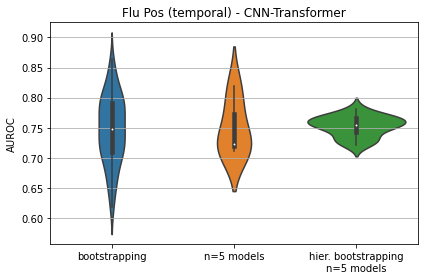

In [11]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, roc_curve
import seaborn as sns

bst_ci = []
for table in tables:
    bst_ci.append(bootstrapping(table, metrics=[roc_auc_score], num_bootstraps=20)["roc_auc_score"])
bst_ci = np.hstack(bst_ci)

model_ci = [roc_auc_score(t["label"], t["pred"]) for t in tables]

hier_ci = hierarchical_bootstrapping(tables, metrics=[roc_auc_score], num_bootstraps=20)["roc_auc_score"]

plt.grid(axis="y")
sns.violinplot(np.array([bst_ci, model_ci, hier_ci]))
plt.ylabel("AUROC")
plt.xticks(ticks=[0, 1, 2], labels=["bootstrapping", "n=5 models", "hier. bootstrapping\nn=5 models"])
plt.title("Flu Pos (temporal) - CNN-Transformer")

plt.tight_layout()

plt.savefig("violin_plots.pdf", bbox_inches='tight', format="pdf")

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/k6/j81s9_qs5hq011qsxpgddgsr0000gn/T/ipykernel_19732/409529285.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.violinplot(np.array([bst_ci, model_ci, hier_ci]))


Text(0.5, 1.0, 'Flu Pos (temporal) - CNN-Transformer')

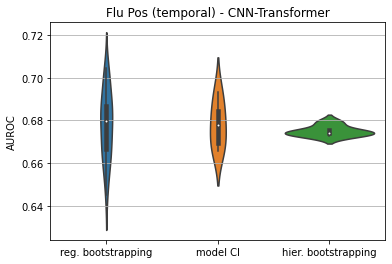

In [131]:
run_ids = search_experiments("CNNClassifier", "HomekitPredictCough", "temporal split", None)
tables = get_prediction_tables(run_ids)

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, roc_curve
import seaborn as sns

bst_ci = []
for table in tables:
    bst_ci.append(bootstrapping(table, metrics=[roc_auc_score], num_bootstraps=5)["roc_auc_score"])
bst_ci = np.hstack(bst_ci)


model_ci = [roc_auc_score(t["label"], t["pred"]) for t in tables]

hier_ci = hierarchical_bootstrapping(tables, metrics=[roc_auc_score], num_bootstraps=5)["roc_auc_score"]


plt.grid(axis="y")
sns.violinplot(np.array([bst_ci, model_ci, hier_ci]))
plt.ylabel("AUROC")
plt.xticks(ticks=[0, 1, 2], labels=["reg. bootstrapping", "model CI", "hier. bootstrapping"])
plt.title("Flu Pos (temporal) - CNN-Transformer")

In [10]:
def bootstrapping(table, metrics=None, num_bootstraps=100):
    """
    Performs a hierarchical bootstrapping of the given prediction tables
    :param tables: list of prediction tables for all n models
    :param metrics: list of metrics to compute hierarchical bootstrapping over
    :param model_bootstraps: number of times to resample with replacement from the models
    :param model_bootstraps: number of times to resample with replacement from the predictions
    :return: nested dictionary with mean and 95% CI for the bootstrapped metrics
    """

    if metrics is None:
        metrics = [roc_auc_score, average_precision_score]

    final_scores = {m.__name__: [] for m in metrics}

    for _ in tqdm(range(num_bootstraps)):


        len_data = len(table)

        # samples with replacement from data
        resampled_data_indices = np.random.choice(np.arange(len_data), len_data, replace=True)

        bootstrapped_preds = table.iloc[resampled_data_indices]
        labels = bootstrapped_preds["label"].to_numpy(int)
        preds = bootstrapped_preds["pred"].to_numpy()

        for ix, metric in enumerate(metrics):
            final_scores[metric.__name__].append(metric(labels, preds))

    return final_scores

<AxesSubplot: >

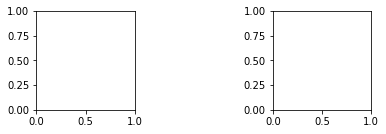

In [12]:
plt.subplot(2, 3, 1)
plt.subplot(2, 3, 3)

In [ ]:
split into 4 quadrants
title 